# **Factbook**
Single-File SQLite Distribution of 260+ World Factbook Country Profiles

In [1]:
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

conn = sqlite3.connect("factbook.db")
schema = conn.execute('''pragma table_info('facts');''').fetchall()

for s in schema:
    print(s)

(0, 'id', 'INTEGER', 1, None, 1)
(1, 'code', 'varchar(255)', 1, None, 0)
(2, 'name', 'varchar(255)', 1, None, 0)
(3, 'area', 'integer', 0, None, 0)
(4, 'area_land', 'integer', 0, None, 0)
(5, 'area_water', 'integer', 0, None, 0)
(6, 'population', 'integer', 0, None, 0)
(7, 'population_growth', 'float', 0, None, 0)
(8, 'birth_rate', 'float', 0, None, 0)
(9, 'death_rate', 'float', 0, None, 0)
(10, 'migration_rate', 'float', 0, None, 0)
(11, 'created_at', 'datetime', 0, None, 0)
(12, 'updated_at', 'datetime', 0, None, 0)


In [2]:
import pandas as pd

def run_query(q):
    return pd.read_sql_query(q,conn)

def show_tables():
    q = '''
        SELECT 
            name, 
            type
        FROM sqlite_master
        WHERE type in ("table", "view")'''
    return run_query(q)

show_tables()

,name,type
0,facts,table
1,sqlite_sequence,table


In [3]:
factbook = run_query("SELECT * FROM facts")
print(factbook.shape)
print(factbook.columns)

(261, 13)
Index(['id', 'code', 'name', 'area', 'area_land', 'area_water', 'population',
       'population_growth', 'birth_rate', 'death_rate', 'migration_rate',
       'created_at', 'updated_at'],
      dtype='object')


This factbook has **261** entries. Each entry contains all basic information about a country such as its name, id, area, population, popolation growth as well as the dates that an entry was created and last updated.

Below are the first 5 entries:

In [4]:
factbook.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51,2015-11-01 13:19:49.461734,2015-11-01 13:19:49.461734
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30,2015-11-01 13:19:54.431082,2015-11-01 13:19:54.431082
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92,2015-11-01 13:19:59.961286,2015-11-01 13:19:59.961286
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00,2015-11-01 13:20:03.659945,2015-11-01 13:20:03.659945
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46,2015-11-01 13:20:08.625072,2015-11-01 13:20:08.625072


## Which countries have the lowest and highest populations?

In [5]:
min_max_population = '''
    SELECT 
        name Country,
        population Population
    FROM facts
    WHERE 
        Population = (
        SELECT min(population)
        FROM facts) OR 
        Population = (
        SELECT max(population)
        FROM facts)'''
run_query(min_max_population)

,Country,Population
0,Antarctica,0
1,World,7256490011


In [6]:
the_world = '''SELECT * FROM facts WHERE name="World"'''
run_query(the_world)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None,2015-11-01 13:39:09.910721,2015-11-01 13:39:09.910721


In [7]:
antarctica = '''SELECT * FROM facts WHERE name="Antarctica"'''
run_query(antarctica)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None,2015-11-01 13:38:44.885746,2015-11-01 13:38:44.885746


**ANTARCTICA**, the southernmost continent and site of the South Pole, is **a virtually uninhabited, ice-covered landmass**. Most cruises to the continent visit the Antarctic Peninsula, which stretches toward South America. It’s known for the Lemaire Channel and Paradise Harbor, striking, iceberg-flanked passageways, and Port Lockroy, a former British research station turned museum. The peninsula’s isolated terrain also shelters rich wildlife, including many penguins.
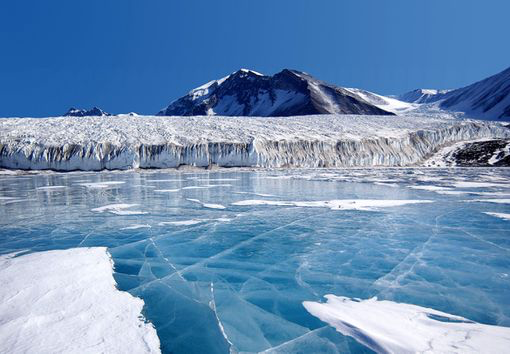

In [8]:
rank_population= """
    WITH facts_rev AS (
        SELECT * FROM facts
        EXCEPT
        SELECT * FROM facts 
            WHERE population=(SELECT max(population) FROM facts))
    
    SELECT 
        name Country,
        population Population
    FROM facts_rev
    ORDER BY population DESC
    LIMIT 10
    """
run_query(rank_population)

,Country,Population
0,China,1367485388
1,India,1251695584
2,European Union,513949445
3,United States,321368864
4,Indonesia,255993674
5,Brazil,204259812
6,Pakistan,199085847
7,Nigeria,181562056
8,Bangladesh,168957745
9,Russia,142423773


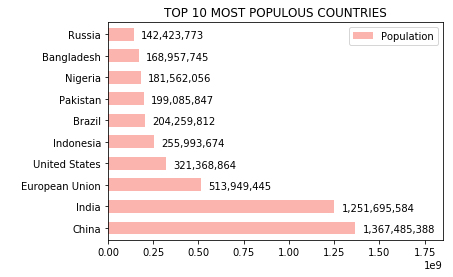

In [9]:
top_10_population = run_query(rank_population)
top_10_population.set_index('Country', inplace=True, drop=True)

top_10_population.plot(kind='barh', colormap=plt.cm.Pastel1, width=0.6) 
plt.title("TOP 10 MOST POPULOUS COUNTRIES")
plt.xlim(0, 1850000000)
plt.ylabel(" ")
for i, country in enumerate(list(top_10_population.index)):
    population = top_10_population.loc[country, 'Population']
    plt.annotate("{:,}".format(population), (population+40000000,i-0.2))
plt.show()

## Which country has the highest population density?

In [10]:
rank_population_density = '''
    SELECT 
        name Country,
        cast(population as Float)/cast(area_land as Float) Population_Density
    FROM facts
    ORDER BY Population_Density DESC
    LIMIT 10'''
run_query(rank_population_density)

,Country,Population_Density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


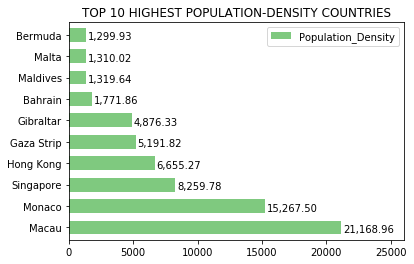

In [11]:
top_10_population_density = run_query(rank_population_density)
top_10_population_density.set_index('Country', inplace=True, drop=True)

top_10_population_density.plot(kind='barh', colormap=plt.cm.Accent, width=0.65)
plt.title("TOP 10 HIGHEST POPULATION-DENSITY COUNTRIES")
plt.xlim(0, 26000)
plt.ylabel("")
for i, country in enumerate(list(top_10_population_density.index)):
    population_density = top_10_population_density.loc[country, 'Population_Density']
    plt.annotate("{0:,.2f}".format(population_density), (population_density+150,i-0.22))
plt.show()

## Which countries have the highest and lowest population growth?

In [12]:
min_max_population_growth = '''
    SELECT 
        name Country,
        population_growth Population_Growth,
        birth_rate Birth_Rate,
        death_rate Death_Rate
    FROM facts
    WHERE 
        Population_Growth = (
        SELECT min(population_growth)
        FROM facts) OR 
        Population_Growth = (
        SELECT max(population_growth)
        FROM facts)'''
run_query(min_max_population_growth)

,Country,Population_Growth,Birth_Rate,Death_Rate
0,South Sudan,4.02,36.91,8.18
1,Holy See (Vatican City),0.00,NaN,NaN
2,Cocos (Keeling) Islands,0.00,NaN,NaN
3,Greenland,0.00,14.48,8.49
4,Pitcairn Islands,0.00,NaN,NaN


**SOUTH SUDAN** officially known as the Republic of South Sudan, is a landlocked country in East-Central Africa. The country gained its independence from Sudan in 2011, making it the newest country with widespread recognition.

**GREENLAND** is a massive island and autonomous Danish territory between the North Atlantic and Arctic oceans. Much of its land surface is covered in ice. Most of its small population lives along the ice-free, fjord-lined coast, particularly in the southwest. Its northerly position, largely above the Arctic Circle, results in natural phenomena such as summer’s midnight sun and winter’s Northern Lights.

In [13]:
min_max_birth_rate = '''
    SELECT 
        name Country,
        population_growth Population_Growth,
        birth_rate Birth_Rate,
        death_rate Death_Rate
    FROM facts
    WHERE 
        Birth_Rate = (
        SELECT min(birth_rate)
        FROM facts) OR 
        Birth_Rate = (
        SELECT max(birth_rate)
        FROM facts)'''
run_query(min_max_birth_rate)

,Country,Population_Growth,Birth_Rate,Death_Rate
0,Monaco,0.12,6.65,9.24
1,Niger,3.25,45.45,12.42


**Monaco** is a tiny independent city-state on France’s Mediterranean coastline known for its upscale casinos, yacht-lined harbor and prestigious Grand Prix motor race, which runs through Monaco’s streets once a year. Monte-Carlo, its major district, is home to an elegant belle-époque casino complex and ornate Salle Garnier opera house. It also has many luxe hotels, boutiques, nightclubs and restaurants.

**Niger**, also called the Niger officially the Republic of the Niger, is a landlocked country in Western Africa named after the Niger River.

In [14]:
Vietnam_Singapore = '''SELECT * FROM facts WHERE name in ("Vietnam", "Singapore")'''
run_query(Vietnam_Singapore)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,created_at,updated_at
0,156,sn,Singapore,697,687,10,5674472,1.89,8.27,3.43,14.05,2015-11-01 13:32:48.898593,2015-11-01 13:32:48.898593
1,192,vm,Vietnam,331210,310070,21140,94348835,0.97,15.96,5.93,0.30,2015-11-01 13:35:42.896553,2015-11-01 13:35:42.896553


## Which country has the highest migration rate?

In [15]:
rank_migration_rate = '''
    SELECT 
        name Country,
        migration_rate Migration_Rate
    FROM facts
    ORDER BY Migration_Rate DESC
    LIMIT 30'''
run_query(rank_migration_rate)

,Country,Migration_Rate
0,Qatar,22.39
1,American Samoa,21.13
2,"Micronesia, Federated States of",20.93
3,Syria,19.79
4,Tonga,17.84
5,British Virgin Islands,17.28
6,Luxembourg,17.16
7,Cayman Islands,14.40
8,Singapore,14.05
9,Nauru,13.63


**MIGRATION RATE** The rate of people moving into a country less the number of people moving out of the same country. High levels of migration, whether in or out of a country, can cause problems relating to unemployment and, in some areas, a reduction or glut in a particular labor force.